In [144]:
# import library
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

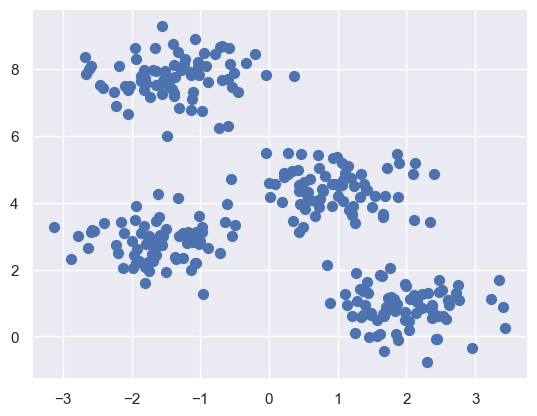

In [145]:
# pengantar k-means
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [146]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

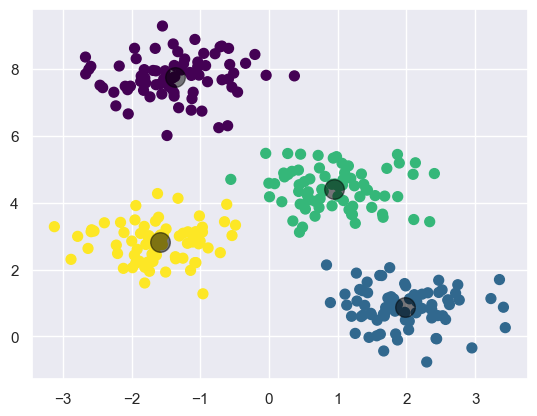

In [147]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Algoritma Expectation-Maximization

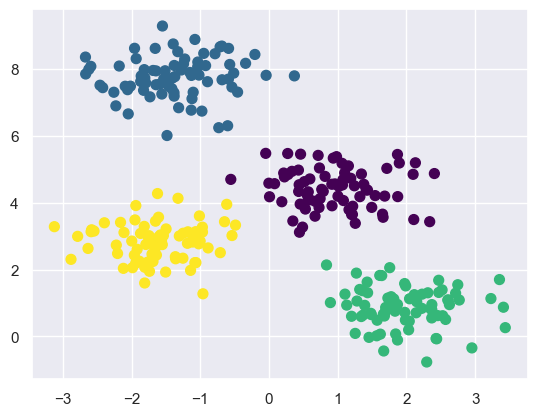

In [148]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. new input label center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. update center from the new point
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. convergence check
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');

### Perubahan Random

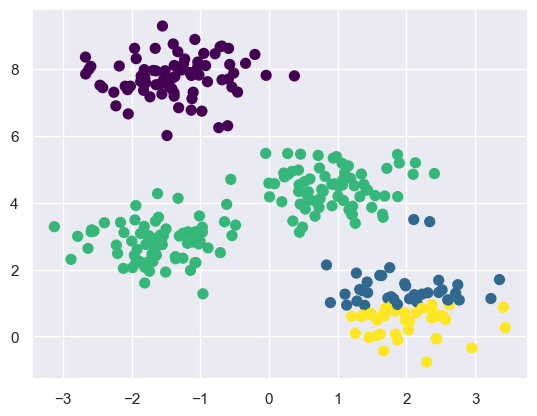

In [149]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');

### Optimalisasi Jumlah Klaster

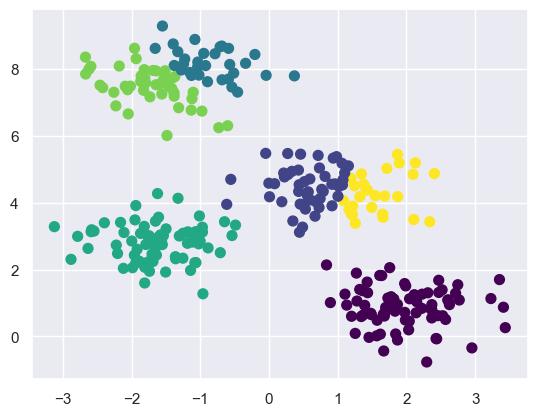

In [150]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### Batas Klaster yang Tidak Selalu Linier

In [151]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

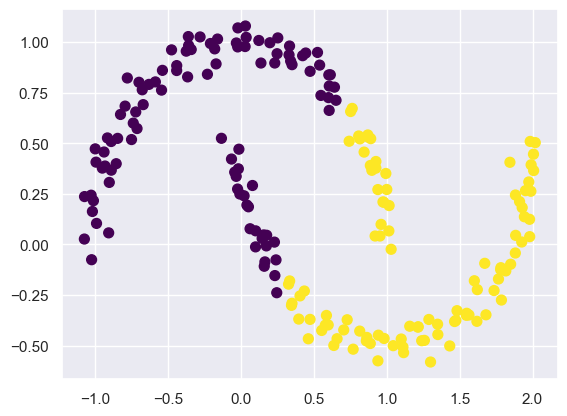

In [152]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');

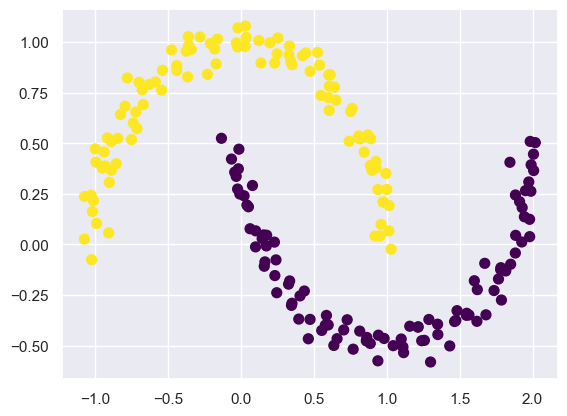

In [153]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

### Contoh Kasus 1: Karakter Angka

In [154]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [155]:
# terapkan K-means
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

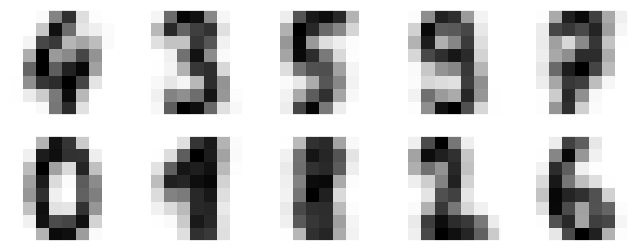

In [156]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [157]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [158]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

In [159]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [160]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# hitung klaster
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# permutasi label
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# hitung akurasi
accuracy_score(digits.target, labels)

0.9426822481914302

### Studi Kasus 2: Komperesi Citra

In [161]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

In [162]:
flower.shape

(427, 640, 3)

In [163]:
data = flower / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [164]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

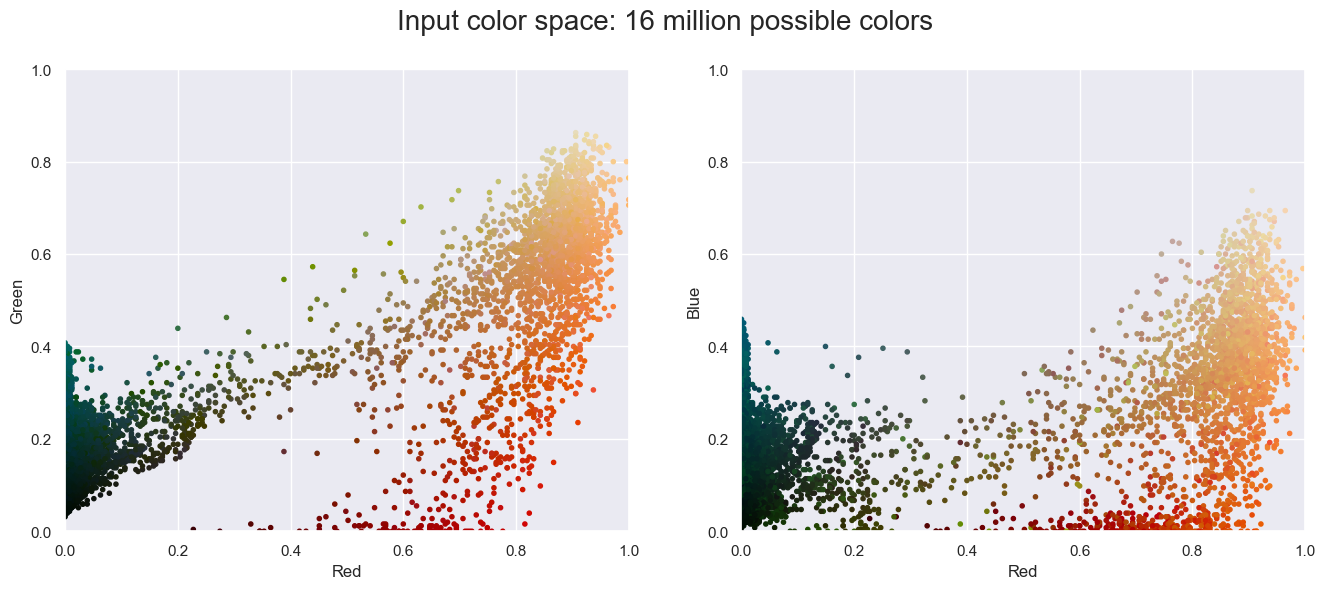

In [165]:
plot_pixels(data, title='Input color space: 16 million possible colors')

In [166]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,title="Reduced color space: 16 colors")

In [167]:
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('16-color Image', size=16);

### Silhoute Method dan Line Chart

In [168]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

sil

[0.49215648268306905,
 0.42110575032701997,
 0.44152892626425333,
 0.4844426215258627,
 0.4976793693950677,
 0.5175345570564969,
 0.5254433492203021,
 0.527280950981404,
 0.514018815011684]

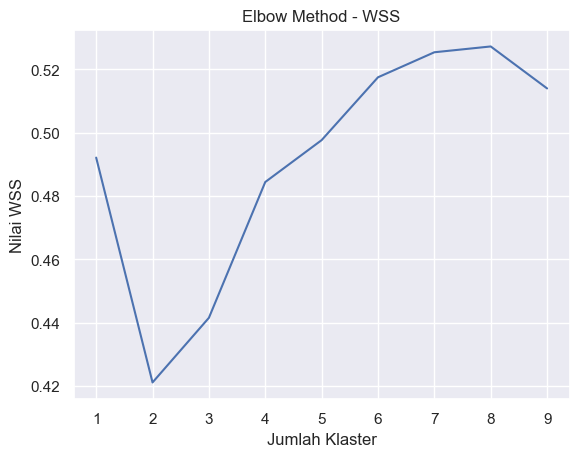

In [169]:
xsil = [1,2,3,4,5,6,7,8,9]

plt.plot(xsil, sil)
plt.title('Elbow Method - WSS')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Nilai WSS')
plt.show()

In [170]:
# import library
import matplotlib.pyplot as plt 
img_dir = 'ocicat.jpg'

In [171]:
# load image
img = plt.imread(img_dir)
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(img);

In [172]:
img.shape

(720, 1080, 3)

In [173]:
data = img / 255.0
data = data.reshape(720 * 1080, 3)
data.shape

(777600, 3)

In [174]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

In [175]:
plot_pixels(data, title='Input color space: 16 million possible colors')

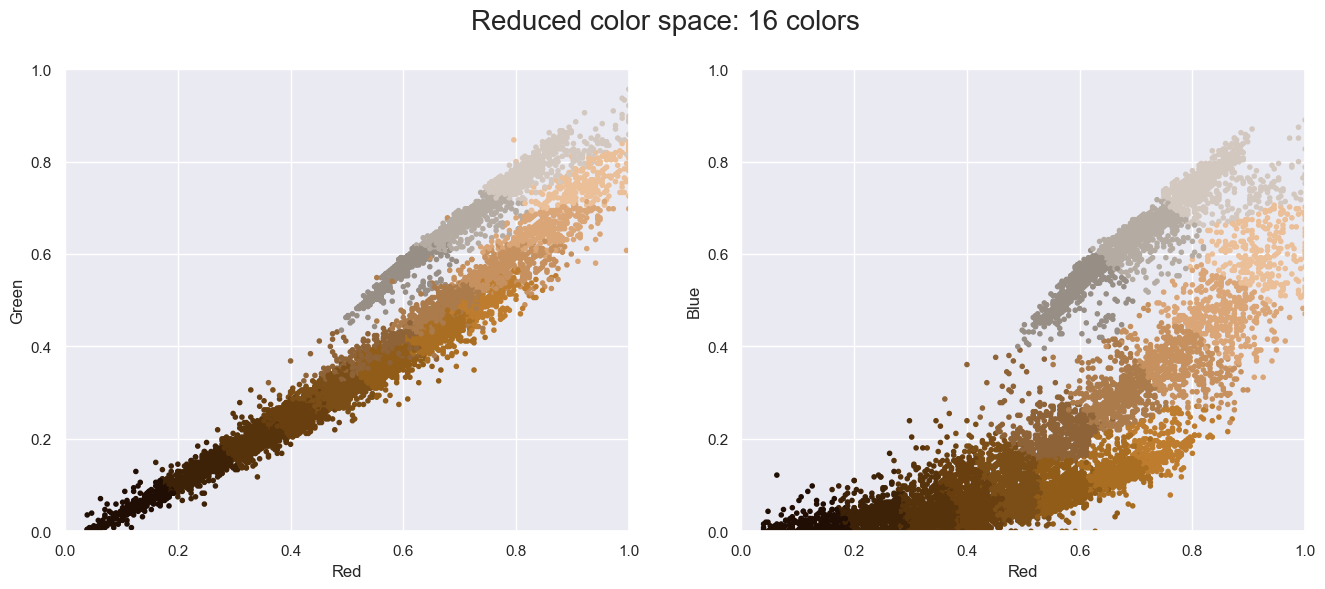

In [176]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,title="Reduced color space: 16 colors")

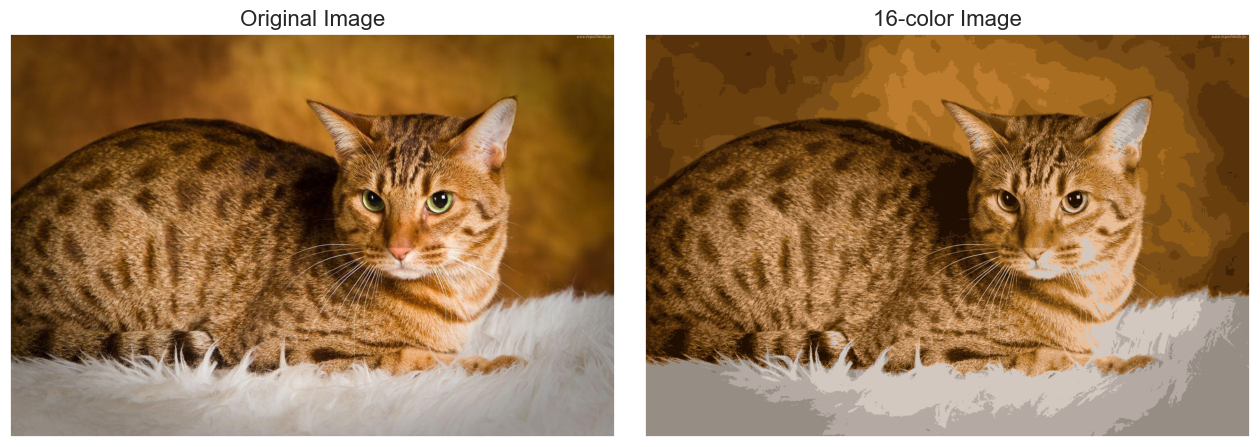

In [177]:
cat = new_colors.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(img)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(cat)
ax[1].set_title('16-color Image', size=16);

### Nomer 2
### Tentukan hasil Elbow Method dan visualisasi line chartnya dengan function sebagai berikut:

In [178]:
# elbow method
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
   
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

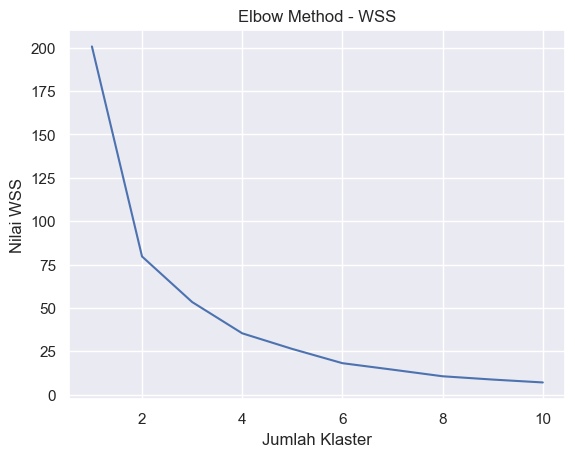

In [179]:
# visualisasi line chart
ycall = [1,2,3,4,5,6,7,8,9,10]

yWSS = calculate_WSS(X, 10)

plt.plot(ycall, yWSS)
plt.title('Elbow Method - WSS')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Nilai WSS')
plt.show()

### Nomer 3
### Tentukan silhoutte dan line chartnya dengan function sebagai berikut:

In [180]:
# silhoutte score
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

sil

[0.49215648268306905,
 0.4235885587196927,
 0.44709257821561577,
 0.48268880990560786,
 0.4976793693950677,
 0.5175345570564969,
 0.5265278795515532,
 0.5265002912756461,
 0.5134230448158297]

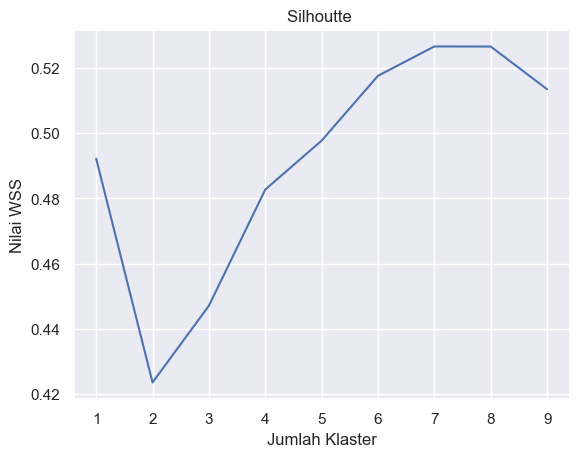

In [181]:
xsil = [1,2,3,4,5,6,7,8,9]

plt.plot(xsil, sil)
plt.title('Silhoutte ')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Nilai WSS')
plt.show()